# Исследование надежности заемщиков.

### Шаг 1. Обзор данных

По результатам анализа выявили:

    1) В столбцах days_employed и total_income пропущено по 2174 значения
    2) Пропущенные значения в столбцах days_employed и total_income составляют по 10,1%, что является существенным значением для выборки. В случае с total_income это может повлиять на конечные результаты исследования.
    3) Возможная причина пропуска данных: 
    - заемщики могут быть ИП или самозанятыми (не начисляется трудовой стаж), 
    - заемщики не предоставили справки о доходах для ежеквартального мониторинга (если только это не ссуды, включенные в портфели однородных ссуд - там мониторинг не проводится), есть вероятность
    - могла измениться методика выдачи кредитов (скоринг) в период заполнения базы данных (например, ранее в анкете данные по трудовому стажу и общему доходу не являлись обязательными)
    4) Для количественных переменных лучшим решением будет заполнение пропусков медианным значением, т.к. это исключает выбросы и в целом для нормального статистического распределения является правильным решением   

In [1]:
# импортируем библиотеки
import pandas as pd
import seaborn as sns

In [2]:
# загрузим датасет
data = pd.read_csv("e:/Яндекс.Практикум/Спринт 03 Предобработка данных/Project_03/data.csv")

# посмотрим, как выглядит датасет
data.info()
display(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


### Шаг 2.1 Заполнение пропусков

По результатам исследования данных обнаружили и исправили аномалии: 

    1) в столбце "children": есть отрицательное значение (-1) и значение в размере 20 детей в 76 строках. Для всего датафрейма таких строк всего 0,35% (76 / 21525), их можно либо удалить, либо заменить значение в столбце "children" с 20 детьми на медианное значение детей по датафрейму. Выберем метод замены медианным значением.
    Аналогично заполним нулевые значения в столбце 'dob_years' медианным значением, т.к. число строк незначительно, а данные по возрасту не планируется использовать 0,47% (101 / 21525).
    
    2) В столбце "total_income" заменим пропуски на медианное значение, 
    
    3) В столбце "days_employed" возьмем все числа по модулю (избавимся от отрицательных значений), затем найдем медиану, которой и заменим пропуски. Столбец более не используется при анализе, поэтому не будем тратить время на устранение выбросов (слишком больших значений, которые явно больше продолжительности нескольких человеческих жизней)

In [3]:
#Проверим, какие есть уникальные значения в каждом из столбцов 
#с разумно конечным числом вариантов значений (все столбцы, кроме days_employed и total_income),
#чтобы сразу увидеть и исправить все аномалии
print(data['children'].unique())
print(data['dob_years'].unique())
print(data['education'].unique())
print(data['education_id'].unique())
print(data['family_status'].unique())
print(data['family_status_id'].unique())
print(data['gender'].unique())
print(data['income_type'].unique())
print(data['debt'].unique())
print(data['purpose'].unique())

#находим количество аномалий по столбцу 'children', где число детей == 20 (с высокой вероятностью это ошибка в данных)
children20 = data.loc[data['children'] == 20]

# находим количество строк с аномалией children20
print("-----------------------------------------------")
print("Количество строк с аномальным количеством детей =", children20['children'].count())

dob_years_zero_count = data.loc[data['dob_years'] == 0]
print("-----------------------------------------------")
print("Количество строк, в которых у заемщиков возраст 0 лет = ", dob_years_zero_count['dob_years'].count())


#ищем минимальный и максимальный общий доход в столбце 'total_income', чтобы оценить датафрейм на аномальные значения
print("-----------------------------------------------")
print("Минимальный доход", data['total_income'].min())
print("Максимальный доход", data['total_income'].max())

#изучим строки со значением dob_years = 0 (т.е. возраст 0 лет, это мы узнали из анализа уникальных значений)
dob_years_zero = data.sort_values(by='dob_years', ascending=True)
display(dob_years_zero.head(30))




[ 1  0  3  2 -1  4 20  5]
[42 36 33 32 53 27 43 50 35 41 40 65 54 56 26 48 24 21 57 67 28 63 62 47
 34 68 25 31 30 20 49 37 45 61 64 44 52 46 23 38 39 51  0 59 29 60 55 58
 71 22 73 66 69 19 72 70 74 75]
['высшее' 'среднее' 'Среднее' 'СРЕДНЕЕ' 'ВЫСШЕЕ' 'неоконченное высшее'
 'начальное' 'Высшее' 'НЕОКОНЧЕННОЕ ВЫСШЕЕ' 'Неоконченное высшее'
 'НАЧАЛЬНОЕ' 'Начальное' 'Ученая степень' 'УЧЕНАЯ СТЕПЕНЬ'
 'ученая степень']
[0 1 2 3 4]
['женат / замужем' 'гражданский брак' 'вдовец / вдова' 'в разводе'
 'Не женат / не замужем']
[0 1 2 3 4]
['F' 'M' 'XNA']
['сотрудник' 'пенсионер' 'компаньон' 'госслужащий' 'безработный'
 'предприниматель' 'студент' 'в декрете']
[0 1]
['покупка жилья' 'приобретение автомобиля' 'дополнительное образование'
 'сыграть свадьбу' 'операции с жильем' 'образование'
 'на проведение свадьбы' 'покупка жилья для семьи' 'покупка недвижимости'
 'покупка коммерческой недвижимости' 'покупка жилой недвижимости'
 'строительство собственной недвижимости' 'недвижимость'
 'строительст

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
6859,1,-260.992722,0,неоконченное высшее,2,гражданский брак,1,F,сотрудник,0,128246.646591,покупка недвижимости
16042,2,-176.404487,0,среднее,1,женат / замужем,0,F,сотрудник,0,137563.630693,жилье
7034,0,366067.781030,0,высшее,0,Не женат / не замужем,4,F,пенсионер,0,263121.074528,образование
21179,2,-108.967042,0,высшее,0,женат / замужем,0,M,компаньон,0,240702.007382,строительство жилой недвижимости
4147,0,-3549.117333,0,среднее,1,в разводе,3,M,сотрудник,0,108130.933212,покупка жилой недвижимости
2469,0,-794.876230,0,среднее,1,гражданский брак,1,F,сотрудник,0,95967.700317,сыграть свадьбу
12297,0,-1572.052136,0,среднее,1,женат / замужем,0,F,сотрудник,0,81994.469031,получение дополнительного образования
270,3,-1872.663186,0,среднее,1,женат / замужем,0,F,сотрудник,0,102166.458894,ремонт жилью
18176,0,-3533.403832,0,Среднее,1,гражданский брак,1,F,сотрудник,1,110485.456043,свадьба
1175,0,370879.508002,0,среднее,1,женат / замужем,0,F,пенсионер,0,313949.845188,получение дополнительного образования


In [4]:
#заполняем пропуски в столбце "children" медианным значением (предварительно исправив отрицательные значения методом abs())
data["children"] = data["children"].abs()
median_children = data["children"].median()
#заполняем все значения в столбце "children", которые равны 20 детям, медианным значением
data.loc[(data["children"] == 20), "children"] = median_children
data["children"] = data["children"].fillna(median_children)

#заполняем все значения в столбце "dob_years", которые равны 0 годам, медианным значением
median_dob_years = data["dob_years"].median()
data.loc[(data["dob_years"] == 0), "dob_years"] = median_dob_years
data["dob_years"] = data["dob_years"].fillna(median_dob_years)

#заполняем пропуски в столбце "total_income" медианным значением
median_income = data["total_income"].median()
data["total_income"] = data["total_income"].fillna(median_income)

#устранение аномалий по столбцу "days_employed" в плане чрезвычайно больших значений (люди обычно столько не живут!) не требуется, 
#так как "days_employed" не используется для аналаиза в дальнейшем, поэтому 
#устраним только пропуски, заменив их на медианное значение (после приведения значений к положительным по модулю)
data["days_employed"] = data["days_employed"].abs()
median_days_employed = data["days_employed"].median()
data["days_employed"] = data["days_employed"].fillna(median_days_employed)

### Шаг 2.2 Проверка данных на аномалии и исправления.

По результатам исследования данных устранли аномалии в столбцах "days_employed", "education", "family_status".
Ранее уже разбирали возможные причины появления таких аномальных значений: не была поставлена защита от ввода экстремальных значений, от ввода отрицательных значений, от написания целей кредита и семейного статуса разным регистром 

In [5]:
# приводим названия категорий по столбцам "education" и "family_status" к нижнему регистру
data["education"] = data["education"].str.lower()
data["family_status"] = data["family_status"].str.lower()

### Шаг 2.3. Изменение типов данных.

Произведем замену вещественного типа данных в столбце total_income на целочисленный. Это снижает нагрузку на ресурсы компьютера, а также позволяет получить значение дохода в целых числах. Причина появления таких данных остается неизвестной, но можно предположить, что использовался перевод из разных валют (маловероятно) либо заемщики указывали доходы за год, а затем математически был получен столбец total_income путем деления на 12 (высокая вероятность)

In [6]:
# приводим вещественный тип данных в столбце total_income к целочисленному типу
data["total_income"] = data["total_income"].astype(int)

# приводим вещественный тип данных в столбце children к целочисленному типу
data["children"] = data["children"].astype(int)

# приводим вещественный тип данных в столбце children к целочисленному типу
data["dob_years"] = data["dob_years"].astype(int)

### Шаг 2.4. Удаление дубликатов.

Проверим данные на дубликаты и удалим дубликаты. Для этого воспользуемся стандартным методом библиотеки pandas - drop_duplicates(). Возможная причина появления дубликатов: ошибки при загрузке баз данных, ошибки при объединении баз данных.  

In [7]:
#найдем количество строк с дубликатами и удалим их
print("Дубликатов до удаления:", data.duplicated().sum())
data = data.drop_duplicates().reset_index(drop=True)

#проверим, что все дубликаты удалены
print("Дубликатов после удаления:", data.duplicated().sum())

Дубликатов до удаления: 72
Дубликатов после удаления: 0


### Шаг 2.5. Формирование дополнительных датафреймов словарей, декомпозиция исходного датафрейма.

Создадим два новых датафрейма со столбцами:
education_id и education — в первом;
family_status_id и family_status — во втором.
Удалим из исходного датафрейма столбцы education и family_status, оставив только их идентификаторы: education_id и family_status_id. Так будет удобно обращаться к ним по идентификатору

In [8]:
#сформируем два датафрейма, удалим из исходного датафрейма столбцы 'education', 'family_status'  
data_education_id = data[["education_id", "education"]].drop_duplicates().reset_index(drop=True)
data_family_status_id = data[["family_status_id", "family_status"]].drop_duplicates().reset_index(drop=True)
data.drop(columns = ['education', 'family_status'], axis = 1, inplace=True)

### Шаг 2.6. Категоризация дохода.

Величина дохода является количественным параметром, поэтому категоризируем доходы следующим образом:

0–30000 — 'E';

30001–50000 — 'D';

50001–200000 — 'C';

200001–1000000 — 'B';

1000001 и выше — 'A'.

Например, кредитополучателю с доходом 25000 нужно назначить категорию 'E', а клиенту, получающему 235000, — 'B'.


In [9]:
# функция для категоризации дохода
def total_income_category(total_income):
    if total_income <= 30000:
        return 'E'
    if 30000 < total_income <=50000:
        return 'D'
    if 50000 < total_income <=200000:
        return 'C'
    if 200000 < total_income <=1000000:
        return 'B'
    if total_income > 1000000:
        return 'A'

data['total_income_category'] = data['total_income'].apply(total_income_category)

### Шаг 2.7. Категоризация целей кредита.
Создадим функцию, которая на основании данных из столбца purpose сформирует новый столбец purpose_category, в который войдут следующие категории:
'операции с автомобилем',
'операции с недвижимостью',
'проведение свадьбы',
'получение образования'.
Например, если в столбце purpose находится подстрока 'на покупку автомобиля', то в столбце purpose_category должна появиться строка 'операции с автомобилем'.


In [10]:
# функция для категоризации по цели кредита
def purpose_category(purpose):
    if purpose in ['покупка жилья', 
                   'операции с жильем', 
                   'покупка жилья для семьи', 
                   'покупка недвижимости', 
                   'покупка коммерческой недвижимости', 
                   'покупка жилой недвижимости', 
                   'строительство собственной недвижимости', 
                   'недвижимость', 
                   'строительство недвижимости', 
                   'операции с коммерческой недвижимостью',
                   'строительство жилой недвижимости', 
                   'жилье', 
                   'операции со своей недвижимостью',
                   'покупка своего жилья',
                   'операции с недвижимостью',
                   'покупка жилья для сдачи',
                   'ремонт жилью']:
        return 'операции с недвижимостью' 
    if purpose in ['приобретение автомобиля', 
                  'на покупку подержанного автомобиля',
                  'на покупку своего автомобиля', 
                  'автомобили',
                  'сделка с подержанным автомобилем',
                  'автомобиль',
                  'свой автомобиль',
                  'сделка с автомобилем',
                  'на покупку автомобиля']:
        return 'операции с автомобилем'
    if purpose in ['дополнительное образование',
                   'образование',
                   'заняться образованием',
                   'получение образования',
                   'получение дополнительного образования',
                   'получение высшего образования',
                   'профильное образование',
                   'высшее образование',
                   'заняться высшим образованием']:
        return 'получение образования'
    if purpose in ['сыграть свадьбу',
                   'на проведение свадьбы',
                   'свадьба']:
        return 'проведение свадьбы'

data["purpose_category"] = data["purpose"].apply(purpose_category)

#проверим, что нет лишних категорий, кроме четырех крупных категорий
display(data["purpose_category"].unique())

array(['операции с недвижимостью', 'операции с автомобилем',
       'получение образования', 'проведение свадьбы'], dtype=object)

### Вопросы исследования.

##### Вопрос 1:

Есть ли зависимость между количеством детей и возвратом кредита в срок?

##### Вывод 1:


Наблюдается зависимость между количеством детей и возвратом кредита в срок: чем больше детей, тем больше вероятность вовремя не заплатить кредит. Заемщики с 5 детьми вовремя платят кредиты, но в базе данных имеется всего лишь 9 записей по таким заемщикам, что это является нерепрезентативным показателем, и данных заемщиков который можно не учитывать в итоговом выводе. Заемщики без детей имеют наименьший (после нерепрезентативных заемщиков с 5 детьми) процент неплатежей, что может быть использовано в оценке кредитоспособности таких клиентов как положительный фактор. При сравнении групп "0 детей" с группой "4 детей детей" можно отметить, что заемщики с 4 детьми на 29% чаще не платят кредиты вовремя, что уже является значительной величиной с точки зрения скоринга. При оценке таких заемщиков рекомендуется применить снижение кредитного рейтинга (увеличивать процентную ставку или отказывать в кредите. Расчеты приведены ниже

In [11]:
# Есть ли зависимость между количеством детей и возвратом кредита в срок? создадим сводную таблицу
display(data.pivot_table(index="children", values="debt", aggfunc="mean"))

,debt
children,
0,0.075604
1,0.091658
2,0.094542
3,0.081818
4,0.097561
5,0.000000


[Text(0.5, 0, 'Количество детей'),
 Text(0, 0.5, 'Доля просрочников'),
 Text(0.5, 1.0, 'Зависимость средней доли клиентов с просрочками от количества детей')]

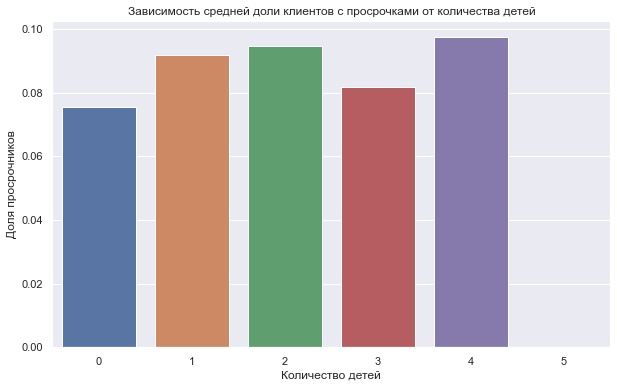

In [12]:
# для визуализации данных построим диаграмму зависимости между количеством детей и возвратом кредита в срок, предварительно 
# сбросив индекс у сводной таблицы (для построения графиков)
df_children_debt = data.pivot_table(index="children", values="debt", aggfunc="mean").reset_index()

sns.set(rc={"figure.figsize":(10, 6)})
sns.barplot(data = df_children_debt, x = "children", y = "debt").set(xlabel='Количество детей', 
                                                                     ylabel='Доля просрочников', 
                                                                     title='Зависимость средней доли клиентов с просрочками от количества детей')

##### Вопрос 2:

Есть ли зависимость между семейным положением и возвратом кредита в срок?

##### Вывод  2:

Наблюдается зависимость между семейным положением и возвратом кредита в срок: заемщики, которые состоят или ранее состояли в официальном браке (были женаты/замужем, вдовы/вдовцы или состоят в разводе) платят по кредитам лучше, чем те, кто не был официально женат (статус "гражданский брак в России, как правило, является синонимом понятия "сожительство" без регистрации брака). Возможные причины: 
1) возможно, вступающие в брак люди обладают большей ответственностью, чем те, кто не состоит или не состоял в браке

2) средний возраст в группах по семейному статусу показывает, что наибольший процент заемщиков, которые не платят вовремя кредиты, наблюдается именно среди тех, кто не был в официальном браке. Вероятно, сочетание факторов "не хочет брать на себя ответственность" и "относительно молод" приводит к завышенной оценке своей кредитоспособности самими заемщиками при получении кредита. 

Расчеты приведены ниже

In [13]:
data_pivot_family_status = data.pivot_table(index=["family_status_id"], values=['dob_years', "debt"], aggfunc="mean")
data_pivot_family_status = data_family_status_id.merge(data_pivot_family_status, on='family_status_id', how='left')
display(data_pivot_family_status)

,family_status_id,family_status,debt,dob_years
0,0,женат / замужем,0.075452,43.713915
1,1,гражданский брак,0.093494,42.281928
2,2,вдовец / вдова,0.065693,56.722628
3,3,в разводе,0.071130,45.869456
4,4,не женат / не замужем,0.097509,38.602847


[Text(0.5, 0, 'Семейный статус'),
 Text(0, 0.5, 'Доля просрочников'),
 Text(0.5, 1.0, 'Зависимость средней доли клиентов с просрочками от семейного статуса')]

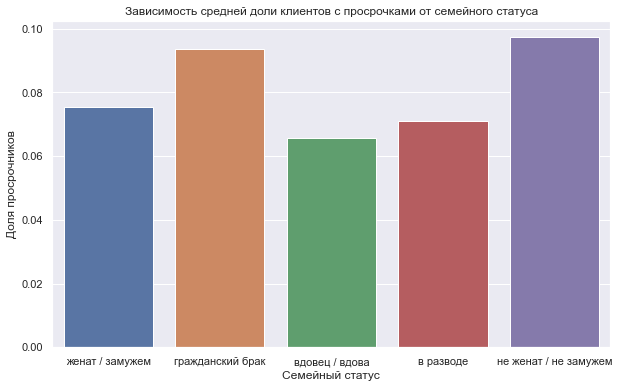

In [14]:
# для визуализации данных построим диаграмму зависимости между семейным статусом и возвратом кредита в срок, предварительно 
# сбросив индекс у сводной таблицы (для построения графиков)
df_family_status_debt = data_pivot_family_status.reset_index()

sns.set(rc={"figure.figsize":(10, 6)})
sns.barplot(data = df_family_status_debt, x = "family_status", y = "debt").set(xlabel='Семейный статус', 
                                                                     ylabel='Доля просрочников', 
                                                                     title='Зависимость средней доли клиентов с просрочками от семейного статуса')


##### Вопрос 3:

Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

##### Вывод 3:

Согласно исследованию, наименьший процент заемщиков, которые не платили кредит вовремя, наблюдается в группе D (доход от 30001 до 50000 руб.). Наибольший процент заемщиков, которые не платили кредит вовремя, отмечается в группе E (заемщики с доходом до 30000 руб.). В оставшихся группах с большими размерами доходов нет четкой зависимости вероятности неплатежей от уровня доходов. Явной прямопропорциональной зависимости не выявлено. Причины неплатежей могут быть разными: от завышенной при скоринге оценке доходов до недостаточного учета рисков при оценке кредитной нагрузки.

In [15]:
display(data.pivot_table(index="total_income_category", values="debt", aggfunc="mean"))

,debt
total_income_category,
A,0.080000
B,0.070621
C,0.084920
D,0.060000
E,0.090909


[Text(0.5, 0, 'Категория дохода заемщика'),
 Text(0, 0.5, 'Доля просрочников'),
 Text(0.5, 1.0, 'Зависимость средней доли клиентов с просрочками от категории дохода')]

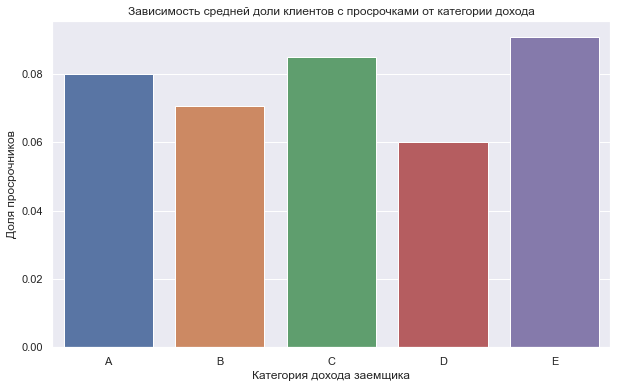

In [16]:
# для визуализации данных построим диаграмму зависимости между доходом и возвратом кредита в срок, предварительно 
# сбросив индекс у сводной таблицы (для построения графиков)
df_income_debt = data.pivot_table(index="total_income_category", values="debt", aggfunc="mean").reset_index()

sns.set(rc={"figure.figsize":(10, 6)})
sns.barplot(data = df_income_debt, x = "total_income_category", y = "debt").set(xlabel='Категория дохода заемщика', 
                                                                     ylabel='Доля просрочников', 
                                                                     title='Зависимость средней доли клиентов с просрочками от категории дохода')


##### Вопрос 4:

Как разные цели кредита влияют на его возврат в срок?

##### Вывод 4:

На средний процент возврата кредита в срок оказывают влияние цели кредита: 
1) по кредитам, взятым на цели, связанные с недвижимостью (покупка, строительство, ремонт и другие), наименьший процент неплатежей в срок. Возможно, это является следствием залоговой политики банка (кредит на приобретение недвижимости практически всегда обеспечивается ипотекой). 

2) по кредитам на покупку авто наибольший процент неплатежей в срок может быть следствием завышенной оценки заемщиком своей кредитоспособности (часто автомобиль обходится дороже общественного транспорта с учетом обслуживания, страхования, поломок и аварий)

3) по кредитам на образование процент неплатежей в срок незначительно уступает кредитам на авто, что может быть следствием завышенной оценки заемщиком своей кредитоспособности (переобучение может быть связано со сменой профессии, что может на какое-то время снизить доходы)

4) по кредитам, связанными со свадьбой, процент неплатежей в срок меньше, чем по кредитам на цели, связанные с автомобилями и образованием, но больше, чем по кредитам на недвижимость. Возможно, кредиты на свадьбу могут частично или полностью окупаться денежными подарками молодоженам при проведении торжества, что позволяет снизить кредитную нагрузку.

In [17]:
display(data.pivot_table(index="purpose_category", values="debt", aggfunc="mean"))

,debt
purpose_category,
операции с автомобилем,0.093590
операции с недвижимостью,0.072334
получение образования,0.092200
проведение свадьбы,0.080069


[Text(0.5, 0, 'Цель кредита'),
 Text(0, 0.5, 'Доля просрочников'),
 Text(0.5, 1.0, 'Зависимость средней доли клиентов с просрочками от цели кредита')]

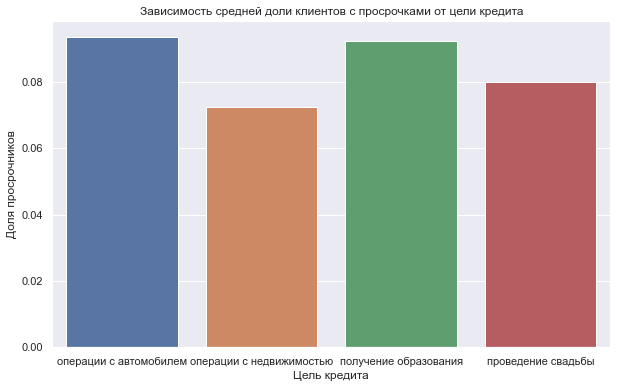

In [18]:
# для визуализации данных построим диаграмму зависимости между целью кредита и возвратом кредита в срок, предварительно 
# сбросив индекс у сводной таблицы (для построения графиков)
df_purpose_debt = data.pivot_table(index="purpose_category", values="debt", aggfunc="mean").reset_index()

sns.set(rc={"figure.figsize":(10, 6)})
sns.barplot(data = df_purpose_debt, x = "purpose_category", y = "debt").set(xlabel='Цель кредита', 
                                                                     ylabel='Доля просрочников', 
                                                                     title='Зависимость средней доли клиентов с просрочками от цели кредита')


## Общий вывод:

</div>
<div class="alert alert-info">


    
По результатам проведенного анализа можно рекомендовать кредитному отделу пересмотреть параметры скоринговой модели для оценки кредитоспособности по физическим лицам и учесть следующие моменты:

1) Существует зависимость между количеством детей и возвратом кредита в срок: чем больше детей, тем больше вероятность вовремя не заплатить кредит. 

2) Существует зависимость между семейным положением и возвратом кредита в срок: заемщики, которые состоят или ранее состояли в официальном браке (были женаты/замужем, вдовы/вдовцы или состоят в разводе) платят по кредитам лучше, чем те, кто не был официально женат

3) Явной прямопропорциональной зависимости между общим доходом и и возвратом кредита в срок не выявлено, но есть категории, которые дисциплинированнее других платят кредиты - это заемщики с доходом до 30001 до 50000 рублей в месяц.

4) На средний процент возврата кредита в срок оказывают влияние цели кредита: кредиты с агрегированными целями "операции с автомобилем" и "получение образования" имееют наибольший процент невозврата в срок.
    
    
    
</div>


